Insert introductory section here

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob

localdata_path = '/kaggle/input/health-professional-shortage-areas'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Import

In [2]:
## Import HPSA files for each healthcare discipline and concatenate to a single dataframe


#Glob files using 'HPSA' to create list of HPSA files
hpsaFiles = glob.glob(localdata_path + '/*HPSA*.csv')

hpsa_dates = ['HPSA Designation Date','HPSA Designation Last Update Date',
         'Withdrawn Date','Data Warehouse Record Create Date']

hpsa_dtypes = {
   'Common Postal Code': 'object',
   'Common State FIPS Code': 'object',
   'Primary State FIPS Code': 'object',
   'State FIPS Code': 'object'
}

# Skip deprecated fields no longer populated for HPSAs and duplicates
hpsa_to_skip = ['Metropolitan Indicator','HPSA Metropolitan Indicator Code',
                'Break in Designation','State Name','State FIPS Code',
                'HPSA Withdrawn Date String','Data Warehouse Record Create Date Text'
                'State Abbreviation','HPSA Resident Civilian Population']

#Read HPSA files into a list and concatenate
hpsaList = []

for file in hpsaFiles:
    df = pd.read_csv(file,index_col=None,
                     usecols=lambda c: not (c.startswith('Unnamed:') | \
                                            (c in hpsa_to_skip)),
                    parse_dates=hpsa_dates,dtype=hpsa_dtypes,
                    na_values = ['Unknown','U']
                    )
    hpsaList.append(df)


    
hpsa_df = pd.concat(hpsaList,axis=0,ignore_index=True)

## Import MUA/P file

muap_dates = ['Designation Date','Medically Underserved Area/Population (MUA/P) Withdrawal Date',
         'MUA/P Update Date','Data Warehouse Record Create Date']


#Read MUAP file
muap_dtypes = {
    'MUA/P ID': 'object',
    'MUA/P Area Code': 'object',
    'County Subdivision FIPS Code': 'object',
    'State FIPS Code': 'object',
    'Primary State FIPS Code': 'object',
    'Common State FIPS Code': 'object',
    'Common State County FIPS Code': 'object',
    'County or County Equivalent Federal Information Processing Standard Code' : 'object'
}

# Skip deprecated fields no longer populated for MUAPs and duplicate fields
muap_to_skip = ['Medically Underserved Area/Population (MUA/P) Metropolitan Indicator',
          'Medically Underserved Area/Population (MUA/P) Metropolitan Description',
          'Break in Designation','HHS Region Name','MUA/P Designation Date String',
          'State Name','Medically Underserved Area/Population (MUA/P) Withdrawal Date in Text Format',
          'State FIPS Code','MUA/P Update Date String','HHS Region Code',
          'Data Warehouse Record Create Date Text']

muap_filename = 'MUA_DET.csv'
muap_df = pd.read_csv(os.path.join(localdata_path,muap_filename),
                    index_col=None,
                    usecols=lambda c: not (c.startswith('Unnamed:') | \
                                           (c in muap_to_skip)),
                    parse_dates = muap_dates,dtype=muap_dtypes)



# Data Exploration - HPSAs

The HPSA dataset contains records representing areas and facilities currently designated as HPSAs ("Designated" status), those in a temporary status to be full withdrawn with the publish of an annual notice in the U.S. Federal Register ("Proposed For Withdrawal" status) and those that are no longer designated as a HPSA ("Withdrawn" status).  In addition, some HPSAs are designated for geographic areas with each record representing a HPSA component such as a single county, county subdivision or census tract. Other HPSAs are designated for individual healthcare facilities or organizations and are represented with a single record.  For the purpose of the exploratory data analysis (EDA), the focus will be on areas-defined HPSAs in "Designated" status.   

In [3]:
#Filter to exclude facility designations and those not in "Designated" status

area_hpsa_types = ['Geographic HPSA','HPSA Population','High Needs Geographic HPSA']
hpsa_df.query('`HPSA Status` == "Designated" & `Designation Type`.isin(@area_hpsa_types)',
              engine='python',inplace=True)

hpsa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30482 entries, 242 to 124691
Data columns (total 58 columns):
 #   Column                                                                    Non-Null Count  Dtype         
---  ------                                                                    --------------  -----         
 0   HPSA Name                                                                 30482 non-null  object        
 1   HPSA ID                                                                   30482 non-null  object        
 2   Designation Type                                                          30482 non-null  object        
 3   HPSA Discipline Class                                                     30482 non-null  object        
 4   HPSA Score                                                                30482 non-null  int64         
 5   Primary State Abbreviation                                                30482 non-null  object        
 6   HPS

Running the info method for this dataframe shows several columns that are expected to contain 0 non-null records as a result of the previously applied filters, include street address information, geographic coordinates and the [Withdrawn Date].

This operation reports that the [HPSA Formal Ratio] column contains null records. This is a known issue in cases in which the denominator is 

<AxesSubplot:xlabel='HPSA FTE', ylabel='count'>

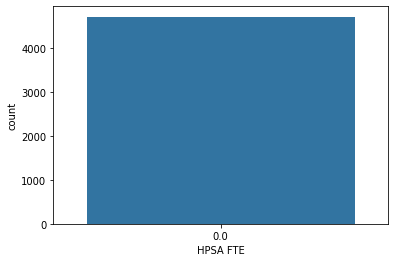

In [4]:
#fig,axis = plt.subplots()
#hpsa_df[hpsa_df['HPSA Formal Ratio'].isnull()]['HPSA FTE'].value_counts().plot(ax=axis,kind='bar')
sns.countplot(x='HPSA FTE',data=hpsa_df[hpsa_df['HPSA Formal Ratio'].isnull()])
#hpsa_df[hpsa_df['HPSA Formal Ratio'].isnull()]['HPSA FTE']

In [5]:
hpsa_df['Designation Type'].value_counts()

HPSA Population               23118
Geographic HPSA                4118
High Needs Geographic HPSA     3246
Name: Designation Type, dtype: int64

In [6]:
hpsa_df.info()
#hpsa_df.head().transpose()
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(hpsa_df)

# Create df removing "Withdrawn" HPSAs

current_hpsa_df = hpsa_df[hpsa_df['HPSA Status'].isin(['Designated','Proposed For Withdrawal'])]
    
with pd.option_context('display.max_columns', 40):
    display(HTML(current_hpsa_df.describe(include=None,datetime_is_numeric=True).to_html()))

# HPSA designation-level categorical columns to summarize
hpsa_desig_cat_cols = ['Designation Type','HPSA Discipline Class','Primary State Abbreviation',
                 'HPSA Status','HPSA Designation Population','Common County Name',
                'Rural Status']

# HPSA component-level cateogorical columns to summarize
hpsa_comp_cat_cols = ['Rural Status','']




<class 'pandas.core.frame.DataFrame'>
Int64Index: 30482 entries, 242 to 124691
Data columns (total 58 columns):
 #   Column                                                                    Non-Null Count  Dtype         
---  ------                                                                    --------------  -----         
 0   HPSA Name                                                                 30482 non-null  object        
 1   HPSA ID                                                                   30482 non-null  object        
 2   Designation Type                                                          30482 non-null  object        
 3   HPSA Discipline Class                                                     30482 non-null  object        
 4   HPSA Score                                                                30482 non-null  int64         
 5   Primary State Abbreviation                                                30482 non-null  object        
 6   HPS

,HPSA Name,HPSA ID,Designation Type,HPSA Discipline Class,HPSA Score,Primary State Abbreviation,HPSA Status,HPSA Designation Date,HPSA Designation Last Update Date,HPSA Geography Identification Number,HPSA Degree of Shortage,Withdrawn Date,HPSA FTE,HPSA Designation Population,% of Population Below 100% Poverty,HPSA Formal Ratio,HPSA Population Type,Primary HHS Region Name,Rural Status,Longitude,Latitude,BHCMIS Organization Identification Number,Common County Name,Common Postal Code,Common Region Name,Common State Abbreviation,Common State County FIPS Code,Common State FIPS Code,Common State Name,County Equivalent Name,County or County Equivalent Federal Information Processing Standard Code,Discipline Class Number,HPSA Address,HPSA City,HPSA Component Name,HPSA Component Source Identification Number,HPSA Component State Abbreviation,HPSA Component Type Code,HPSA Component Type Description,HPSA Designation Population Type Description,HPSA Estimated Served Population,HPSA Estimated Underserved Population,HPSA Population Type Code,HPSA Postal Code,HPSA Provider Ratio Goal,HPSA Shortage,HPSA Status Code,HPSA Type Code,Primary State FIPS Code,Primary State Name,Provider Type,Rural Status Code,State Abbreviation,State and County Federal Information Processing Standard Code,U.S. - Mexico Border 100 Kilometer Indicator,U.S. - Mexico Border County Indicator,Data Warehouse Record Create Date,Data Warehouse Record Create Date Text
242,LI - Des Moines,1198086691,HPSA Population,Primary Care,17,IA,Designated,2021-06-10,2021-06-10,1915390270,Not applicable,NaT,3.2193,76939.0,16.3,23899:1,Low Income Population HPSA,Region 7,Non-Rural,NaN,NaN,NaN,"Polk County, IA",NaN,Region 7,IA,19153,19,Iowa,Polk,153,1,NaN,NaN,"Bloomfield township, Polk County, Iowa",NaN,IA,CSD,County Subdivision,Low Income Population HPSA,9658.0,67281.0,LI,NaN,3000:1,22.4307,D,Hpsa Pop,19,Iowa,Not Applicable,N,IA,19153,N,N,2022-02-20,2022/02/20
243,LI - Des Moines,1198086691,HPSA Population,Primary Care,17,IA,Designated,2021-06-10,2021-06-10,1915390987,Not applicable,NaT,3.2193,76939.0,16.3,23899:1,Low Income Population HPSA,Region 7,Non-Rural,NaN,NaN,NaN,"Polk County, IA",NaN,Region 7,IA,19153,19,Iowa,Polk,153,1,NaN,NaN,"Des Moines township, Polk County, Iowa",NaN,IA,CSD,County Subdivision,Low Income Population HPSA,9658.0,67281.0,LI,NaN,3000:1,22.4307,D,Hpsa Pop,19,Iowa,Not Applicable,N,IA,19153,N,N,2022-02-20,2022/02/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124690,Grand Canyon Village,6044613817,High Needs Geographic HPSA,Dental Health,15,AZ,Designated,2017-12-01,2021-09-10,04005001700,Not applicable,NaT,0.0000,9709.0,14.9,NaN,Geographic Population,Region 9,Rural,NaN,NaN,NaN,"Coconino County, AZ",NaN,Region 9,AZ,04005,04,Arizona,Coconino,005,6,NaN,NaN,"Census Tract 17, Coconino County, Arizona",NaN,AZ,CT,Census Tract,Geographic Population,0.0,9709.0,TRC,NaN,4000:1,2.4300,D,Hpsa Geo HN,04,Arizona,Not Applicable,R,AZ,04005,N,N,2022-02-20,2022/02/20
124691,Grand Canyon Village,6044613817,High Needs Geographic HPSA,Dental Health,15,AZ,Designated,2017-12-01,2021-09-10,04005002300,Not applicable,NaT,0.0000,9709.0,14.9,NaN,Geographic Population,Region 9,Rural,NaN,NaN,NaN,"Coconino County, AZ",NaN,Region 9,AZ,04005,04,Arizona,Coconino,005,6,NaN,NaN,"Census Tract 23, Coconino County, Arizona",NaN,AZ,CT,Census Tract,Geographic Population,0.0,9709.0,TRC,NaN,4000:1,2.4300,D,Hpsa Geo HN,04,Arizona,Not Applicable,R,AZ,04005,N,N,2022-02-20,2022/02/20


,HPSA Score,HPSA Designation Date,HPSA Designation Last Update Date,Withdrawn Date,HPSA FTE,HPSA Designation Population,% of Population Below 100% Poverty,Longitude,Latitude,Discipline Class Number,HPSA Estimated Served Population,HPSA Estimated Underserved Population,HPSA Shortage,Data Warehouse Record Create Date
count,30482.000000,30482,30482,0,30482.000000,3.048200e+04,30482.000000,0.0,0.0,30482.000000,30482.000000,30482.000000,30482.000000,30482
mean,15.753100,2015-08-04 14:56:57.885965568,2021-03-24 13:54:19.392428288,NaT,5.669463,8.834561e+04,21.287521,NaN,NaN,4.254248,30263.803622,58081.809560,11.232496,2022-02-20 00:00:00
min,3.000000,1978-03-05 00:00:00,2016-08-27 00:00:00,NaT,0.000000,9.800000e+01,2.400000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,2022-02-20 00:00:00
25%,14.000000,2016-08-15 00:00:00,2021-08-06 00:00:00,NaT,0.427200,2.570100e+04,14.300000,NaN,NaN,1.000000,2500.500000,13498.000000,2.675500,2022-02-20 00:00:00
50%,16.000000,2018-12-10 00:00:00,2021-09-10 00:00:00,NaT,2.240000,6.883300e+04,19.300000,NaN,NaN,6.000000,14072.000000,44420.000000,6.800000,2022-02-20 00:00:00
75%,18.000000,2021-08-17 00:00:00,2021-09-10 00:00:00,NaT,7.175000,1.290730e+05,26.800000,NaN,NaN,7.000000,37728.000000,84777.000000,16.429300,2022-02-20 00:00:00
max,26.000000,2022-02-18 00:00:00,2022-02-18 00:00:00,NaT,74.450000,1.668717e+06,6616.000000,NaN,NaN,7.000000,932000.000000,934705.000000,81.130000,2022-02-20 00:00:00
std,3.404144,NaN,NaN,NaN,9.264503,8.092929e+04,38.864657,NaN,NaN,2.760865,48573.005819,56068.982369,11.738986,NaN


In [7]:
current_hpsa_df['HPSA Status'].unique()

array(['Designated'], dtype=object)